## How to predict stream using a trained model

#Here we show how to predict continous waveform using a trained u-net model (unet.ckpt-590000)

# load modules

In [1]:
from __future__ import print_function

import quakenet.data_pipeline_unet as dp
from quakenet.data_io import load_stream
import numpy as np
import pandas as pd
import tensorflow as tf
import quakenet.config as config
import argparse
import os,shutil
import time
from obspy.core import read
from obspy.core.utcdatetime import UTCDateTime
import tqdm
import glob
import setproctitle
import sys
sys.path.append('./bin')
import unet
import fnmatch
import matplotlib
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Subroutine 

In [2]:
def preprocess_stream(stream):
    stream = stream.detrend('constant')
    ##add by mingzhao,2017/12/2
    stream =stream.filter('bandpass', freqmin=0.5, freqmax=20)
    ##########
    return stream
def fetch_window_data(stream,j):
    """fetch data from a stream window and dump in np array"""
    data = np.empty((3001, j))
    for i in range(j):
        data[:, i] = stream[i].data.astype(np.float32)
    data = np.expand_dims(data, 0)
    return data

# input parameters

In [3]:
n_events = 0
time_start = time.time()
stream_path =""
checkpoint_path ="unet_capital/unet.ckpt-590000"
batch_size=1 
output_dir="output/predict_from_stream"
window_size=30
window_step=31
image_size=3001
stream_file="./mseed/PWU20080720223000.mseed"

# the continous waveform

/home/zm/miniconda3/envs/unet_cea/lib/python2.7/site-packages/obspy/core/trace.py:2176: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(self.data.dtype, float):


 + Preprocess stream 3 Trace(s) in Stream:
XX.PWU..BHN | 2008-07-20T22:30:00.000000Z - 2008-07-20T22:32:00.000000Z | 100.0 Hz, 12001 samples
XX.PWU..BHE | 2008-07-20T22:30:00.000000Z - 2008-07-20T22:32:00.000000Z | 100.0 Hz, 12001 samples
XX.PWU..BHZ | 2008-07-20T22:30:00.000000Z - 2008-07-20T22:32:00.000000Z | 100.0 Hz, 12001 samples
 -- Stream is ready, starting detection


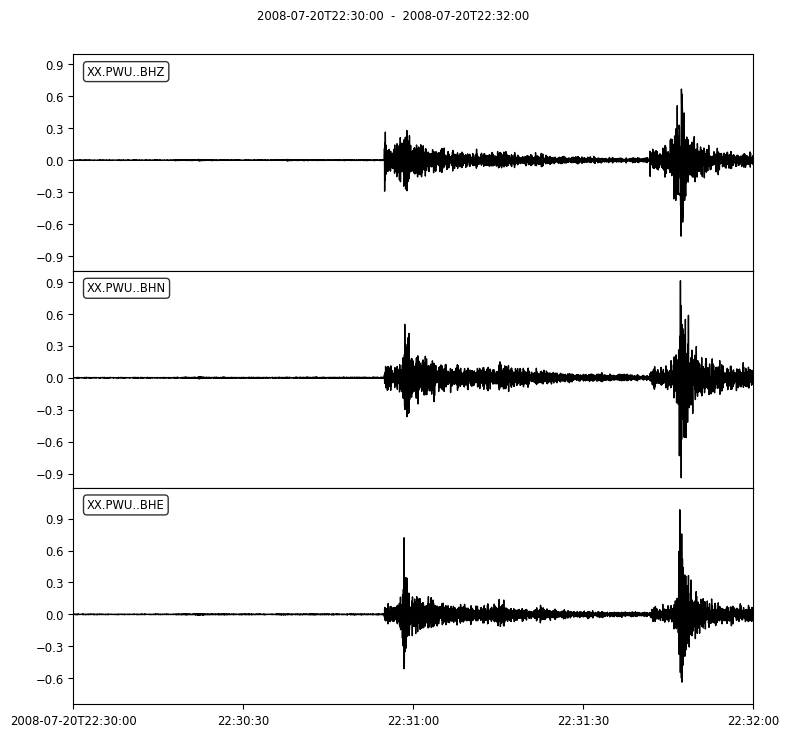

In [4]:
stream = load_stream(stream_file)
stream =stream.normalize()

print (" + Preprocess stream {}".format(stream))
stream = preprocess_stream(stream)
print (" -- Stream is ready, starting detection")
stream.plot()

# the predict process using unet (with tensorflow)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.max_pooling1d instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
input_shape,output_shape Tensor("upsample6/Shape:0", shape=(3,), dtype=int32) Tensor("upsample6/stack:0", shape=(3,), dtype=int32)
num_filters_in, output_shape,weights 128 Tensor("upsample6/stack:0", shape=(3,), dtype=int32) <tf.Variable 'upsample6/weights:0' shape=(8, 128, 128) dtype=float32_ref>
input_shape,output_shape Tensor("upsample7/Shape:0", shape=(3,), dtype=int32) Tensor("upsample7/stack:0", shape=(3,), dtype=int32)
num_filters_in, output_shape,weights 128 Tensor("upsample7/stack:0", shape=(3,), dtype=int32) <tf.Variable 'upsample7/weights:0' shape=(8, 128, 128) dtype=float32_ref>
input_shape,output_shape Tensor("upsample8/Shape:0", shape=(3,), dtype=int32) Tensor("upsample8/stack:0", shape=(3,), dtype=int32)
num_filters_in, o

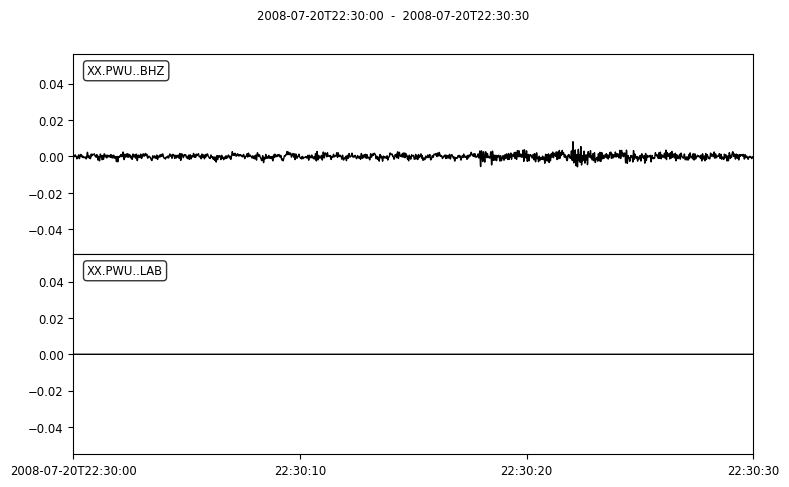

predicted_images_value (1, 3001)


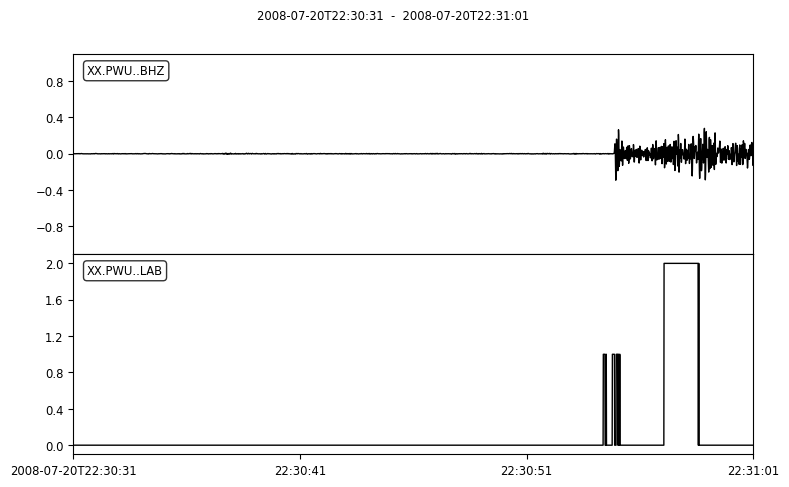

predicted_images_value (1, 3001)


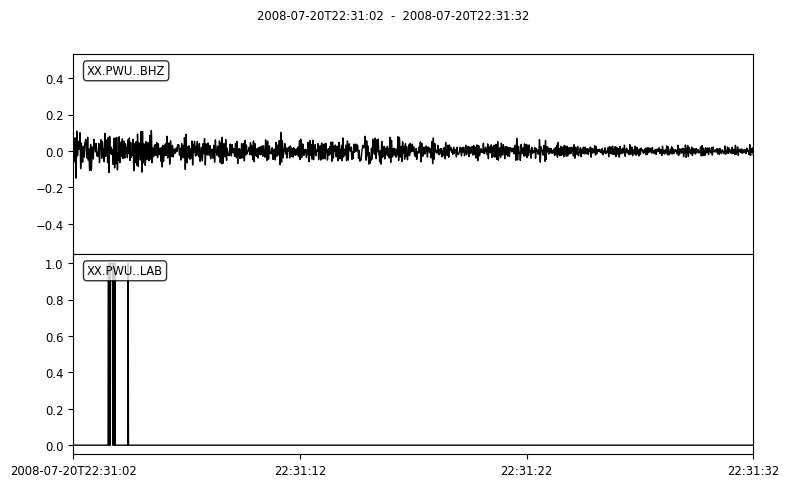

predicted_images_value (1, 3001)


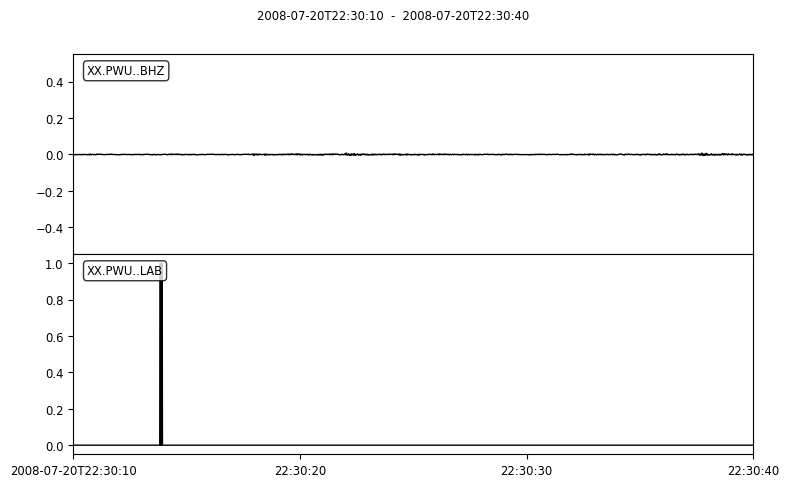

predicted_images_value (1, 3001)


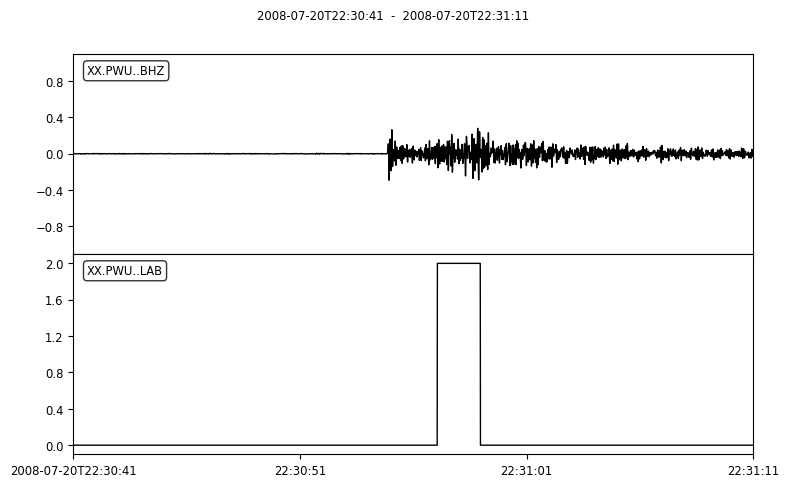

predicted_images_value (1, 3001)


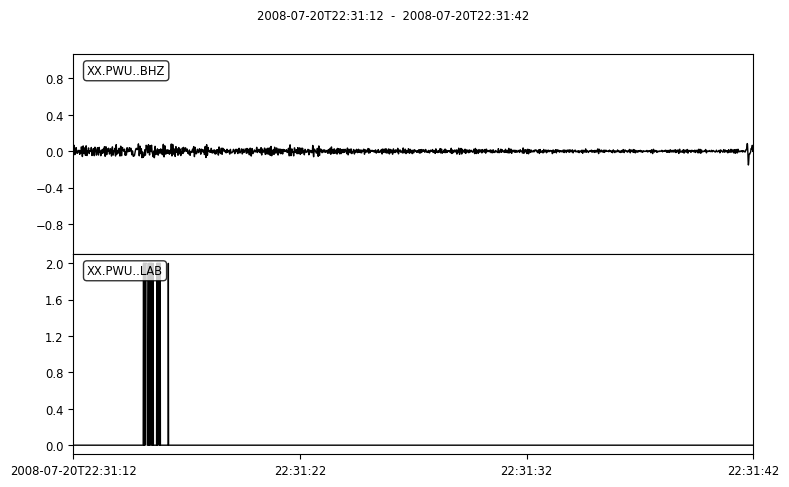

predicted_images_value (1, 3001)


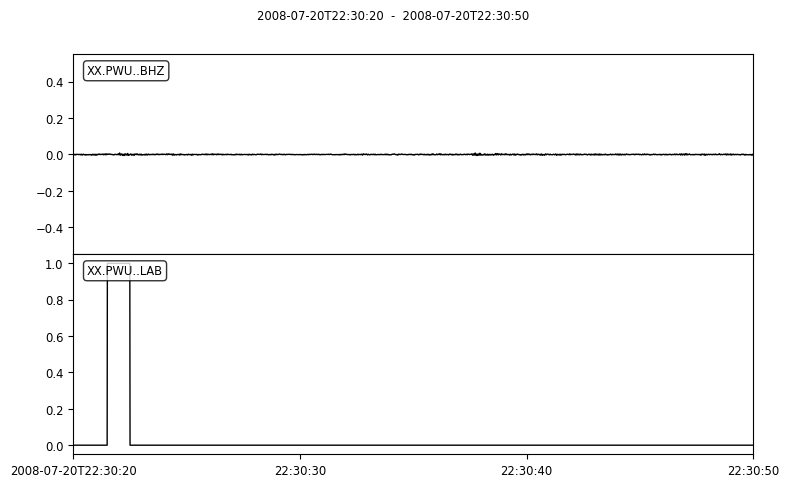

predicted_images_value (1, 3001)


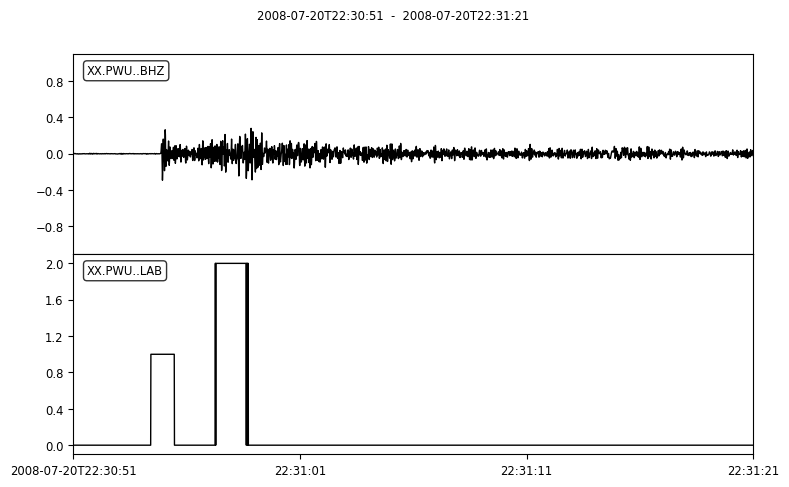

predicted_images_value (1, 3001)


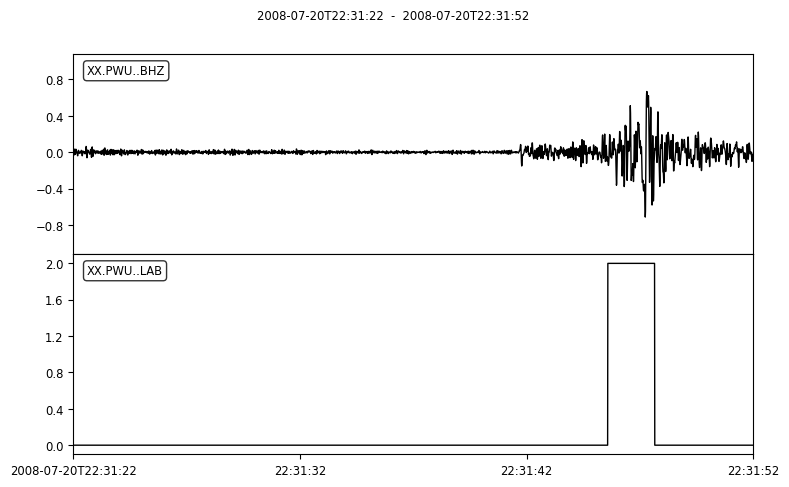

In [5]:
samples = {
        'data': tf.placeholder(tf.float32,
                                   shape=(batch_size, image_size, 3),
                                   name='input_data')}
with tf.Session() as sess:

    logits = unet.build_30s(samples['data'], 3, False)
    
    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

    sess.run(init_op)
    saver = tf.train.Saver()

    if not tf.gfile.Exists(checkpoint_path + '.meta'):
        raise ValueError("Can't find checkpoint file")
    else:
        print('[INFO    ]\tFound checkpoint file, restoring model.')
        saver.restore(sess, checkpoint_path)
    coord = tf.train.Coordinator()

    threads = tf.train.start_queue_runners(sess=sess, coord=coord)


    lists = np.arange(0,30,10)
    for i in lists:
        win_gen = stream.slide(window_length=window_size, step=window_step,offset=i,
                                                                                 include_partial_windows=False)
        for idx, win in enumerate(win_gen):
            predicted_images = unet.predict(logits, batch_size, image_size)
            to_fetch = [predicted_images,samples['data']]

            feed_dict = {samples['data']: fetch_window_data(win.copy().normalize(),3)}
   
            predicted_images_value, images_value = sess.run(to_fetch,feed_dict)

            win_filtered = win.copy()
            lab = win_filtered[2].copy()
            lab.stats.channel = "LAB"
                            # lab =win[0].copy()

            print("predicted_images_value", predicted_images_value.shape)
            lab.data[...] = predicted_images_value[0, :]
            win_filtered += lab
            win_filtered[-2:].plot()
                            # Wait for threads to finish.
            coord.join(threads)